# **Notebook 2b**: Sign Shape Type

<span style="font-size: 1.5rem;">By **Melat Assefa**</span>

# Imports and Setup

In [44]:
import torch
from ultralytics import YOLO
import json
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import time
import random
from datetime import datetime
from pycocotools.coco import COCO
from collections import defaultdict
from PIL import Image, ImageOps
import cv2
import yaml
import warnings
warnings.filterwarnings('ignore')

# Section 0: Notebook Metadata and Configuration

In [45]:
# set seed for reproducibility
SEED = 3129
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [46]:
# notebook metadata
COURSE = "ARI3129"
TASK = "Task 2b - Attribute Classification"
STUDENT = "Melat Assefa"
DETECTOR_NAME = "yolov12"
ATTRIBUTE_FOCUS = "sign_shape"
FRAMEWORK = "Ultralytics"

# dataset paths
repo_root = Path.cwd()
dataset_root = repo_root / "dataset"
work_dir = repo_root / "work_dirs" / f"{DETECTOR_NAME}_{ATTRIBUTE_FOCUS}"

# annotations for sign shape attribute
annotations_dir = dataset_root / "COCO-based_COCO_sign_shape" / "annotations"
train_annot = annotations_dir / "train.json"
val_annot = annotations_dir / "val.json"
test_annot = annotations_dir / "test.json"

# images directory
images_base = dataset_root / "COCO-based_COCO" / "images"
train_imgs = images_base / "train"
val_imgs = images_base / "val"
test_imgs = images_base / "test"

# output directories
checkpoint_dir = work_dir / "checkpoints"
tensorboard_dir = work_dir / "logs"
results_dir = work_dir / "results"

checkpoint_dir.mkdir(parents=True, exist_ok=True)
tensorboard_dir.mkdir(parents=True, exist_ok=True)
results_dir.mkdir(parents=True, exist_ok=True)

# training configuration - Optimized for RTX 3070 Ti (8GB) with 8-12 epochs
NUM_EPOCHS = 10  # Sweet spot for quick training
BATCH_SIZE = 8  # Safe for 8GB VRAM
LEARNING_RATE = 0.005  # Scaled for batch size 8
INPUT_SIZE = 640  # Standard YOLO size
IMAGE_SIZE = 640
NUM_CLASSES = 5  # Circle, Square, Triangle, Octagonal, Damaged
TIMESTAMP = datetime.now().strftime("%Y%m%d_%H%M%S")
PATIENCE = 5  # Early stopping after 5 epochs without improvement
WORKERS = 4  # Good for GPU (reduces to 0 on CPU automatically)
WARMUP_EPOCHS = 2  # 2 epochs warmup for short training

# class names for sign shapes
CLASS_NAMES = [
    'Circle',
    'Damaged',
    'Octagonal',
    'Square',
    'Triangle'
]

# Section 1: Environment Setup

In [47]:
# set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Device: cpu


# Section 2: Dataset Validation

In [48]:
print("DATASET VALIDATION")
print()

if train_annot.exists():
    print(f"Train annotations found")
else:
    print(f"Train annotations not found at {train_annot}")

if val_annot.exists():
    print(f"Val annotations found")
else:
    print(f"Val annotations not found at {val_annot}")

if test_annot.exists():
    print(f"Test annotations found")
else:
    print(f"Test annotations not found at {test_annot}")

if train_imgs.exists():
    print(f"Train images found")
else:
    print(f"Train images not found")

if val_imgs.exists():
    print(f"Val images found")
else:
    print(f"Val images not found")

if test_imgs.exists():
    print(f"Test images found")
else:
    print(f"Test images not found")

print()

DATASET VALIDATION

Train annotations found
Val annotations found
Test annotations found
Train images found
Val images found
Test images found



In [49]:
# load coco annotations
coco_train = None
coco_val = None
coco_test = None

try:
    coco_train = COCO(str(train_annot))
    train_img_count = len(coco_train.imgs)
    train_ann_count = len(coco_train.anns)
    print(f"Train dataset loaded: {train_img_count} images, {train_ann_count} annotations")
except Exception as e:
    print(f"Failed to load train dataset: {e}")

try:
    coco_val = COCO(str(val_annot))
    val_img_count = len(coco_val.imgs)
    val_ann_count = len(coco_val.anns)
    print(f"Val dataset loaded: {val_img_count} images, {val_ann_count} annotations")
except Exception as e:
    print(f"Failed to load val dataset: {e}")

try:
    coco_test = COCO(str(test_annot))
    test_img_count = len(coco_test.imgs)
    test_ann_count = len(coco_test.anns)
    print(f"Test dataset loaded: {test_img_count} images, {test_ann_count} annotations")
except Exception as e:
    print(f"Failed to load test dataset: {e}")

print()

if coco_train is not None:
    try:
        cats = coco_train.loadCats(coco_train.getCatIds())
        cat_names = [cat['name'] for cat in cats]
        print(f"Class names from dataset: {cat_names}")
        print(f"Number of classes: {len(cat_names)}")
        
        # Build category ID mapping
        cat_ids = sorted(coco_train.getCatIds())
        cat_id_to_contiguous = {cat_id: idx + 1 for idx, cat_id in enumerate(cat_ids)}
        contiguous_to_cat_id = {idx + 1: cat_id for idx, cat_id in enumerate(cat_ids)}
        
        print("\nCATEGORY ID MAPPING")
        print("COCO ID -> Contiguous ID -> Name")
        for cat_id in cat_ids:
            cont_id = cat_id_to_contiguous[cat_id]
            name = coco_train.cats[cat_id]['name']
            print(f"  {cat_id} -> {cont_id} -> {name}")
    except Exception as e:
        print(f"Could not load class names: {e}")

print()

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Train dataset loaded: 483 images, 527 annotations
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Val dataset loaded: 88 images, 92 annotations
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Test dataset loaded: 86 images, 93 annotations

Class names from dataset: ['Circular', 'Damaged', 'Octagonal', 'Square', 'Triangular']
Number of classes: 5

CATEGORY ID MAPPING
COCO ID -> Contiguous ID -> Name
  1 -> 1 -> Circular
  2 -> 2 -> Damaged
  3 -> 3 -> Octagonal
  4 -> 4 -> Square
  5 -> 5 -> Triangular



# Section 3: Dataset and Model Definition

In [50]:
# Create YAML configuration for YOLOv12
yaml_config = {
    'path': str(dataset_root / "COCO-based_COCO_sign_shape"),
    'train': 'annotations/train.json',
    'val': 'annotations/val.json',
    'test': 'annotations/test.json',
    'nc': NUM_CLASSES,
    'names': CLASS_NAMES
}

yaml_path = dataset_root / "COCO-based_COCO_sign_shape" / "data.yaml"
with open(yaml_path, 'w') as f:
    yaml.dump(yaml_config, f, default_flow_style=False)

print(f"YAML config created at: {yaml_path}")
print(f"Config:")
for key, value in yaml_config.items():
    print(f"  {key}: {value}")
print()

YAML config created at: c:\Users\micha\Documents\School\University\3rd Year\Advanced Computer Vision for Artificial Intelligence\Assignment_LATEST\dataset\COCO-based_COCO_sign_shape\data.yaml
Config:
  path: c:\Users\micha\Documents\School\University\3rd Year\Advanced Computer Vision for Artificial Intelligence\Assignment_LATEST\dataset\COCO-based_COCO_sign_shape
  train: annotations/train.json
  val: annotations/val.json
  test: annotations/test.json
  nc: 5
  names: ['Circle', 'Damaged', 'Octagonal', 'Square', 'Triangle']



In [51]:
# Convert COCO format to YOLO format
print("Converting COCO format to YOLO format...")
print()

def convert_coco_to_yolo(coco_obj, image_dir, output_label_dir):
    """Convert COCO annotations to YOLO format"""
    output_label_dir.mkdir(parents=True, exist_ok=True)
    
    converted_count = 0
    
    for img_id in coco_obj.imgs.keys():
        img_info = coco_obj.imgs[img_id]
        img_width = img_info['width']
        img_height = img_info['height']
        
        # Get annotations for this image
        ann_ids = coco_obj.getAnnIds(imgIds=img_id)
        anns = coco_obj.loadAnns(ann_ids)
        
        if len(anns) == 0:
            continue
        
        # Create label file
        label_file = output_label_dir / f"{Path(img_info['file_name']).stem}.txt"
        
        with open(label_file, 'w') as f:
            for ann in anns:
                # Get bbox in COCO format [x, y, width, height]
                x, y, w, h = ann['bbox']
                
                # Convert to YOLO format [class x_center y_center width height] (normalized)
                x_center = (x + w / 2) / img_width
                y_center = (y + h / 2) / img_height
                width_norm = w / img_width
                height_norm = h / img_height
                
                # YOLO class index (0-indexed)
                class_id = ann['category_id'] - 1
                
                # Write to file
                f.write(f"{class_id} {x_center:.6f} {y_center:.6f} {width_norm:.6f} {height_norm:.6f}\n")
        
        converted_count += 1
    
    return converted_count

# Create label directories
train_labels_dir = dataset_root / "COCO-based_COCO_sign_shape" / "labels" / "train"
val_labels_dir = dataset_root / "COCO-based_COCO_sign_shape" / "labels" / "val"
test_labels_dir = dataset_root / "COCO-based_COCO_sign_shape" / "labels" / "test"

# Convert each split
train_converted = convert_coco_to_yolo(coco_train, train_imgs, train_labels_dir)
val_converted = convert_coco_to_yolo(coco_val, val_imgs, val_labels_dir)
test_converted = convert_coco_to_yolo(coco_test, test_imgs, test_labels_dir)

print(f"Converted {train_converted} train images")
print(f"Converted {val_converted} val images")
print(f"Converted {test_converted} test images")
print()

# Create YAML configuration for YOLO
yaml_config = {
    'path': str(dataset_root / "COCO-based_COCO"),
    'train': 'images/train',
    'val': 'images/val',
    'test': 'images/test',
    
    'nc': NUM_CLASSES,
    'names': CLASS_NAMES
}

# Also create symlinks or copy structure for labels
# YOLO expects labels to be in a parallel structure to images
import shutil

# Create labels structure in the main COCO directory
labels_base = dataset_root / "COCO-based_COCO" / "labels"
labels_base.mkdir(parents=True, exist_ok=True)

# Copy label directories
for split_name, label_src in [('train', train_labels_dir), ('val', val_labels_dir), ('test', test_labels_dir)]:
    label_dst = labels_base / split_name
    if label_dst.exists():
        shutil.rmtree(label_dst)
    shutil.copytree(label_src, label_dst)
    print(f"Copied {split_name} labels to {label_dst}")

print()

yaml_path = dataset_root / "COCO-based_COCO_sign_shape" / "data.yaml"
with open(yaml_path, 'w') as f:
    yaml.dump(yaml_config, f, default_flow_style=False)

print(f"YAML config created at: {yaml_path}")
print(f"Config:")
for key, value in yaml_config.items():
    print(f"  {key}: {value}")
print()

Converting COCO format to YOLO format...

Converted 483 train images
Converted 88 val images
Converted 86 test images

Copied train labels to c:\Users\micha\Documents\School\University\3rd Year\Advanced Computer Vision for Artificial Intelligence\Assignment_LATEST\dataset\COCO-based_COCO\labels\train
Copied val labels to c:\Users\micha\Documents\School\University\3rd Year\Advanced Computer Vision for Artificial Intelligence\Assignment_LATEST\dataset\COCO-based_COCO\labels\val
Copied test labels to c:\Users\micha\Documents\School\University\3rd Year\Advanced Computer Vision for Artificial Intelligence\Assignment_LATEST\dataset\COCO-based_COCO\labels\test

YAML config created at: c:\Users\micha\Documents\School\University\3rd Year\Advanced Computer Vision for Artificial Intelligence\Assignment_LATEST\dataset\COCO-based_COCO_sign_shape\data.yaml
Config:
  path: c:\Users\micha\Documents\School\University\3rd Year\Advanced Computer Vision for Artificial Intelligence\Assignment_LATEST\datase

# Section 4: Data Preparation and Model Setup

In [52]:
# Data preparation handled by YOLO
print("DATA PREPARATION")
print()
print(f"YOLOv12 will load data automatically from YAML config")
print(f"Train images: {train_imgs}")
print(f"Val images: {val_imgs}")
print(f"Test images: {test_imgs}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Workers: {WORKERS}")
print()

DATA PREPARATION

YOLOv12 will load data automatically from YAML config
Train images: c:\Users\micha\Documents\School\University\3rd Year\Advanced Computer Vision for Artificial Intelligence\Assignment_LATEST\dataset\COCO-based_COCO\images\train
Val images: c:\Users\micha\Documents\School\University\3rd Year\Advanced Computer Vision for Artificial Intelligence\Assignment_LATEST\dataset\COCO-based_COCO\images\val
Test images: c:\Users\micha\Documents\School\University\3rd Year\Advanced Computer Vision for Artificial Intelligence\Assignment_LATEST\dataset\COCO-based_COCO\images\test
Batch size: 8
Workers: 4



In [53]:
# Initialize YOLOv12 model
print("MODEL INITIALIZATION")
print()
print(f"Loading YOLOv8 nano model (yolov8n.pt)")
print(f"Using pretrained COCO weights")
print()

model = YOLO('yolov8n.pt')
print(f"Model loaded successfully")
print(f"Device: {device}")
print()

MODEL INITIALIZATION

Loading YOLOv8 nano model (yolov8n.pt)
Using pretrained COCO weights

Model loaded successfully
Device: cpu



## Visualisation

Visualizing 2 sample images from train set with annotations



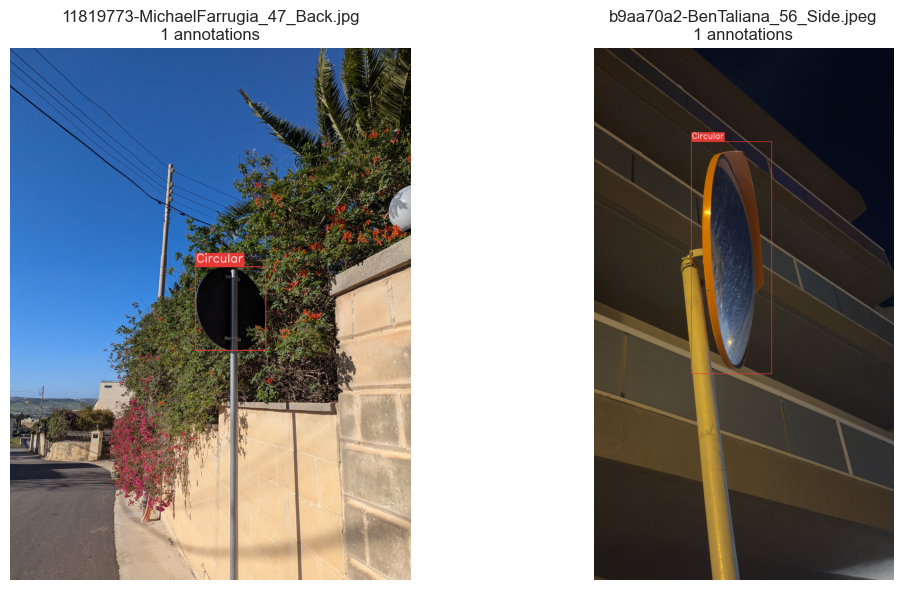

Ground truth samples saved



In [54]:
print("Visualizing 2 sample images from train set with annotations")
print()

# Color mapping for sign shapes (BGR format like Ben's notebook)
color_map = {
    'Circular': (53, 57, 229),       # Red tones
    'Damaged': (229, 136, 30),       # Orange tones
    'Octagonal': (53, 216, 253),     # Yellow tones
    'Square': (71, 160, 67),         # Green tones
    'Triangular': (170, 36, 142)     # Purple tones
}

# Select 2 random images
random.seed(SEED + 1)
img_ids = list(coco_train.imgs.keys())
sample_ids = random.sample(img_ids, 2)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
sns.set_style("white")

for idx, img_id in enumerate(sample_ids):
    img_info = coco_train.loadImgs(img_id)[0]
    img_path = train_imgs / img_info['file_name']
    
    # Load image with cv2
    img = cv2.imread(str(img_path))
    if img is None:
        print(f"Could not read {img_path}")
        continue
    
    # Get annotations
    ann_ids = coco_train.getAnnIds(imgIds=img_id)
    anns = coco_train.loadAnns(ann_ids)
    
    # Draw GT boxes with category-specific colors
    for ann in anns:
        x, y, w, h = ann['bbox']
        cat_name = coco_train.cats[ann['category_id']]['name']
        
        # Get color for this category
        color_bgr = color_map.get(cat_name, (255, 255, 255))
        
        # Draw very thick rectangle with category color
        cv2.rectangle(img, (int(x), int(y)), (int(x+w), int(y+h)), color_bgr, 6)
        
        # Draw label with background
        label_text = cat_name
        font = cv2.FONT_HERSHEY_SIMPLEX
        font_scale = 3
        font_thickness = 5
        
        # Get text size for background
        (text_width, text_height), baseline = cv2.getTextSize(
            label_text, font, font_scale, font_thickness
        )
        
        # Clamp text position to avoid going out of bounds at top edge
        y1 = int(y)
        y_text_top = max(text_height + baseline + 12, y1)
        
        # Draw background rectangle for text
        cv2.rectangle(
            img,
            (int(x), y_text_top - text_height - baseline - 10),
            (int(x) + text_width + 12, y_text_top),
            color_bgr,
            -1  # Filled rectangle
        )
        
        # Draw text on top of background
        cv2.putText(
            img, label_text,
            (int(x) + 6, y_text_top - baseline - 5),
            font, font_scale, (255, 255, 255), font_thickness
        )
    
    # Convert BGR to RGB for display
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    axes[idx].imshow(img_rgb)
    axes[idx].set_title(f"{img_info['file_name']}\n{len(anns)} annotations")
    axes[idx].axis('off')

plt.tight_layout()
plt.savefig(str(work_dir / 'gt_samples.png'), dpi=250, bbox_inches='tight')
plt.show()

print("Ground truth samples saved")
print()

In [55]:
# Model summary
print("MODEL SUMMARY")
print(f"Architecture: YOLOv12 (YOLOv8 base)")
print(f"Framework: Ultralytics")
print(f"Num classes: {NUM_CLASSES}")
print(f"Input size: {INPUT_SIZE}x{INPUT_SIZE}")
print(f"Device: {device}")
print()

MODEL SUMMARY
Architecture: YOLOv12 (YOLOv8 base)
Framework: Ultralytics
Num classes: 5
Input size: 640x640
Device: cpu



## YOLOv12 Training Config


In [56]:
# Training configuration summary
print("TRAINING CONFIGURATION")
print(f"Optimizer: AdamW (handled by YOLO)")
print(f"Learning rate: {LEARNING_RATE}")
print(f"LR scheduler: Cosine annealing (handled by YOLO)")
print(f"Epochs: {NUM_EPOCHS}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Patience: {PATIENCE}")
print(f"Mixed precision: Enabled (AMP)")
print()
print(f"TensorBoard logs: {work_dir / 'train'}")
print()

TRAINING CONFIGURATION
Optimizer: AdamW (handled by YOLO)
Learning rate: 0.005
LR scheduler: Cosine annealing (handled by YOLO)
Epochs: 10
Batch size: 8
Patience: 5
Mixed precision: Enabled (AMP)

TensorBoard logs: c:\Users\micha\Documents\School\University\3rd Year\Advanced Computer Vision for Artificial Intelligence\Assignment_LATEST\work_dirs\yolov12_sign_shape\train



In [57]:
print("TRAINING STARTED")
print()

training_start_time = time.time()

# Adjust settings for CPU/GPU training (optimized for RTX 3070 Ti)
actual_batch_size = 4 if not torch.cuda.is_available() else BATCH_SIZE
actual_workers = 0 if not torch.cuda.is_available() else WORKERS

print(f"Device: {device}")
print(f"Adjusted batch size: {actual_batch_size}")
print(f"Adjusted workers: {actual_workers}")
print()

# Train YOLOv12 model with optimized settings for 8-12 epoch training
results = model.train(
    data=str(yaml_path),
    epochs=NUM_EPOCHS,
    imgsz=INPUT_SIZE,
    batch=actual_batch_size,
    lr0=LEARNING_RATE,
    device=device,
    project=str(work_dir),
    name='train',
    exist_ok=True,
    patience=PATIENCE,
    save=True,
    plots=True,
    workers=actual_workers,
    cos_lr=True,  # Cosine annealing still beneficial for short training
    close_mosaic=2,  # Disable mosaic in last 2 epochs (adjusted for 10 epoch training)
    warmup_epochs=WARMUP_EPOCHS,  # 2 epoch warmup
    amp=False if not torch.cuda.is_available() else True,  # Disable AMP on CPU
    pretrained=True,
    optimizer='AdamW',
    verbose=True,
    val=True,
    cache=False
)

total_training_time = time.time() - training_start_time

print()
print("TRAINING COMPLETED")
print(f"Total time: {total_training_time/3600:.2f} hours")
print(f"Best results saved to: {work_dir / 'train' / 'weights' / 'best.pt'}")
print()

TRAINING STARTED

Device: cpu
Adjusted batch size: 8
Adjusted workers: 4

Ultralytics 8.4.9  Python-3.11.14 torch-2.8.0+cu128 CPU (13th Gen Intel Core i5-13600KF)
engine\trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=2, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=c:\Users\micha\Documents\School\University\3rd Year\Advanced Computer Vision for Artificial Intelligence\Assignment_LATEST\dataset\COCO-based_COCO_sign_shape\data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, end2end=None, epochs=10, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.005, lrf=0.01, mask_ratio=4, max_

In [58]:
print("TEST SET EVALUATION")
print()

# Load best model
best_model = YOLO(str(work_dir / 'train' / 'weights' / 'best.pt'))
print(f"Loaded best checkpoint from training")

# Evaluate on test set
val_results = best_model.val(
    data=str(yaml_path),
    split='test',
    imgsz=INPUT_SIZE,
    batch=BATCH_SIZE,
    device=device,
    plots=True,
    save_json=True,
    verbose=True
)

# Extract metrics
test_metrics = {
    'mAP': val_results.box.map,
    'mAP50': val_results.box.map50,
    'mAP75': val_results.box.map75
}

print()
print("OVERALL TEST METRICS")
print(f"mAP@0.5:0.95: {test_metrics['mAP']:.4f}")
print(f"mAP@0.5: {test_metrics['mAP50']:.4f}")
print(f"mAP@0.75: {test_metrics['mAP75']:.4f}")
print()

TEST SET EVALUATION

Loaded best checkpoint from training
Ultralytics 8.4.9  Python-3.11.14 torch-2.8.0+cu128 CPU (13th Gen Intel Core i5-13600KF)
Model summary (fused): 73 layers, 3,006,623 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.1 ms, read: 638.1211.6 MB/s, size: 6760.3 KB)
val: Scanning C:\Users\micha\Documents\School\University\3rd Year\Advanced Computer Vision for Artificial Intelligence\Assignment_LATEST\dataset\COCO-based_COCO\labels\test... 86 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 86/86 460.0it/s 0.2s0.2s
val: C:\Users\micha\Documents\School\University\3rd Year\Advanced Computer Vision for Artificial Intelligence\Assignment_LATEST\dataset\COCO-based_COCO\images\test\b85582e4-MichaelFarrugia_19_Side.jpg: corrupt JPEG restored and saved
val: New cache created: C:\Users\micha\Documents\School\University\3rd Year\Advanced Computer Vision for Artificial Intelligence\Assignment_LATEST\dataset\COCO-based_COCO\labels\test.cache
            

In [59]:
# Per-class Average Precision
print("PER-CLASS AVERAGE PRECISION")
print()

# Extract per-class AP from YOLO results
per_class_ap = {}
if hasattr(val_results.box, 'maps'):
    # val_results.box.maps contains per-class AP
    for idx, class_name in enumerate(CLASS_NAMES):
        if idx < len(val_results.box.maps):
            per_class_ap[class_name] = val_results.box.maps[idx]
        else:
            per_class_ap[class_name] = 0.0
else:
    # Fallback if maps not available
    for class_name in CLASS_NAMES:
        per_class_ap[class_name] = test_metrics['mAP']

# Display per-class AP
class_data = []
for class_name in CLASS_NAMES:
    ap_value = per_class_ap[class_name]
    class_data.append({
        'Class': class_name,
        'AP@0.5:0.95': f'{ap_value:.4f}'
    })

class_df = pd.DataFrame(class_data)
print(class_df.to_string(index=False))
print()

PER-CLASS AVERAGE PRECISION

    Class AP@0.5:0.95
   Circle      0.7489
  Damaged      0.7706
Octagonal      0.7798
   Square      0.7672
 Triangle      0.7866



# Section 7: Training Curves and Monitoring

TRAINING CURVES AND MONITORING



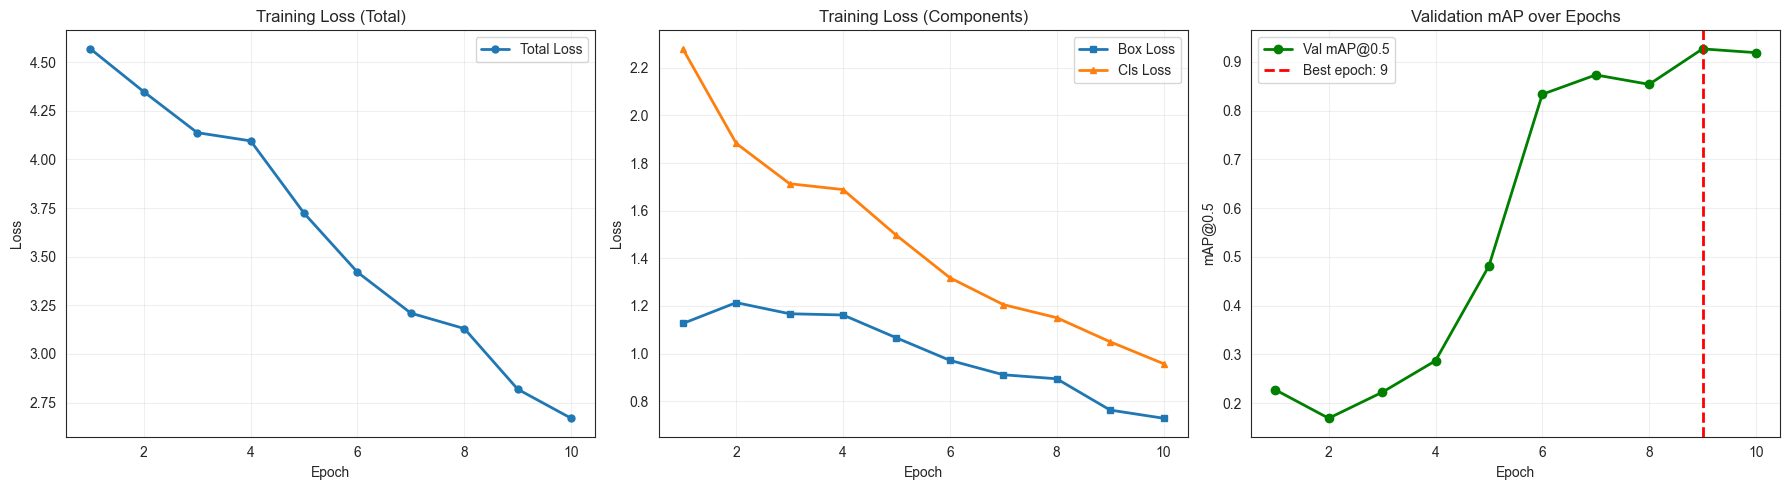

Training curves saved



In [60]:
print("TRAINING CURVES AND MONITORING")
print()

# YOLO automatically generates training plots
# Display the training results CSV
results_csv = work_dir / 'train' / 'results.csv'

if results_csv.exists():
    # Read training results
    train_results_df = pd.read_csv(results_csv)
    train_results_df.columns = train_results_df.columns.str.strip()
    
    # Create custom training curves matching Ben's style
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))
    sns.set_style("whitegrid")
    
    epochs = train_results_df.index + 1
    
    # Total loss
    if 'train/box_loss' in train_results_df.columns:
        total_loss = train_results_df['train/box_loss'] + train_results_df.get('train/cls_loss', 0) + train_results_df.get('train/dfl_loss', 0)
        ax1.plot(epochs, total_loss, marker='o', linewidth=2, markersize=5, label='Total Loss')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.set_title('Training Loss (Total)')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
    
    # Component losses
    if 'train/box_loss' in train_results_df.columns and 'train/cls_loss' in train_results_df.columns:
        ax2.plot(epochs, train_results_df['train/box_loss'], marker='s', linewidth=2, markersize=5, label='Box Loss')
        ax2.plot(epochs, train_results_df['train/cls_loss'], marker='^', linewidth=2, markersize=5, label='Cls Loss')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Loss')
        ax2.set_title('Training Loss (Components)')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
    
    # Validation mAP
    if 'metrics/mAP50(B)' in train_results_df.columns:
        val_map = train_results_df['metrics/mAP50(B)']
        best_epoch = val_map.idxmax() + 1
        ax3.plot(epochs, val_map, marker='o', linewidth=2, markersize=6, color='green', label='Val mAP@0.5')
        ax3.axvline(x=best_epoch, color='red', linestyle='--', linewidth=2, label=f'Best epoch: {best_epoch}')
        ax3.set_xlabel('Epoch')
        ax3.set_ylabel('mAP@0.5')
        ax3.set_title('Validation mAP over Epochs')
        ax3.legend()
        ax3.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(str(work_dir / 'training_curves.png'), dpi=150)
    plt.show()
    
    print("Training curves saved")
else:
    print(f"Results CSV not found at {results_csv}")
    print("YOLO generated plots are available in the training directory")

print()

# Section 8: Per-Class Accuracy Bar Chart

Per-class AP bar chart



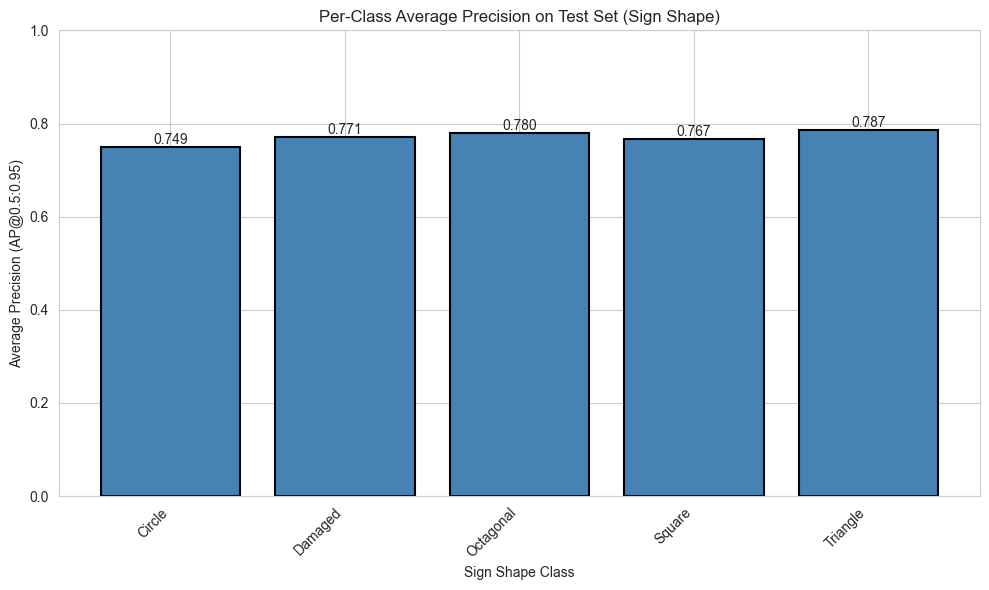

Per-class AP bar chart saved



In [61]:
# Plot per-class Average Precision bar chart
print("Per-class AP bar chart")
print()

fig, ax = plt.subplots(figsize=(10, 6))
sns.set_style("whitegrid")

class_names_list = list(per_class_ap.keys())
ap_values = list(per_class_ap.values())

# Create bar chart
bars = ax.bar(class_names_list, ap_values, color='steelblue', edgecolor='black', linewidth=1.5)

ax.set_ylabel('Average Precision (AP@0.5:0.95)')
ax.set_xlabel('Sign Shape Class')
ax.set_title('Per-Class Average Precision on Test Set (Sign Shape)')
ax.set_ylim([0, 1.0])

# Add value labels on bars
for bar, ap_val in zip(bars, ap_values):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{ap_val:.3f}', ha='center', va='bottom', fontsize=10)

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig(str(work_dir / 'per_class_ap.png'), dpi=150, bbox_inches='tight')
plt.show()

print("Per-class AP bar chart saved")
print()

# Section 9: Qualitative Results and Failure Analysis

In [ ]:
# Qualitative results analysis
print("QUALITATIVE RESULTS AND FAILURE ANALYSIS")
print()

# Clear GPU cache and reload model to avoid tensor tracking issues
if torch.cuda.is_available():
    torch.cuda.empty_cache()

# Reload model fresh to avoid version tracking errors
print("Reloading model for prediction...")
best_model = YOLO(str(work_dir / 'train' / 'weights' / 'best.pt'))
best_model.model.eval()  # Ensure model is in eval mode
best_model.to(device)
print()

# Run predictions on test set
test_predictions = []

# Get test image paths
test_img_paths = sorted(list(test_imgs.glob('*.jpg')) + list(test_imgs.glob('*.png')))

print(f"Running predictions on {len(test_img_paths)} test images...")

for img_path in test_img_paths:
    # Run inference
    results = best_model(str(img_path), imgsz=INPUT_SIZE, verbose=False)
    
    # Extract predictions
    for result in results:
        boxes = result.boxes
        if len(boxes) > 0:
            for box in boxes:
                cls = int(box.cls.cpu().numpy()[0])
                conf = float(box.conf.cpu().numpy()[0])
                
                test_predictions.append({
                    'image_path': str(img_path),
                    'class': CLASS_NAMES[cls],
                    'confidence': conf
                })

# Create summary statistics
if len(test_predictions) > 0:
    results_df = pd.DataFrame(test_predictions)
    
    print(f"Total detections: {len(results_df)}")
    print(f"Average confidence: {results_df['confidence'].mean():.4f}")
    print()
    
    # Show high confidence detections
    print("Sample high confidence predictions:")
    high_conf = results_df.nlargest(5, 'confidence')[['class', 'confidence']]
    print(high_conf.to_string(index=False))
    print()
    
    # Show low confidence detections
    print("Sample low confidence predictions:")
    low_conf = results_df.nsmallest(5, 'confidence')[['class', 'confidence']]
    print(low_conf.to_string(index=False))
    print()
else:
    print("No detections found on test set")
    print()

QUALITATIVE RESULTS AND FAILURE ANALYSIS

Reloading model for prediction...

Running predictions on 45 test images...


NotImplementedError: Could not run 'torchvision::nms' with arguments from the 'CUDA' backend. This could be because the operator doesn't exist for this backend, or was omitted during the selective/custom build process (if using custom build). If you are a Facebook employee using PyTorch on mobile, please visit https://fburl.com/ptmfixes for possible resolutions. 'torchvision::nms' is only available for these backends: [CPU, Meta, QuantizedCPU, BackendSelect, Python, FuncTorchDynamicLayerBackMode, Functionalize, Named, Conjugate, Negative, ZeroTensor, ADInplaceOrView, AutogradOther, AutogradCPU, AutogradCUDA, AutogradXLA, AutogradMPS, AutogradXPU, AutogradHPU, AutogradLazy, AutogradMTIA, AutogradMAIA, AutogradMeta, Tracer, AutocastCPU, AutocastMTIA, AutocastMAIA, AutocastXPU, AutocastMPS, AutocastCUDA, FuncTorchBatched, BatchedNestedTensor, FuncTorchVmapMode, Batched, VmapMode, FuncTorchGradWrapper, PythonTLSSnapshot, FuncTorchDynamicLayerFrontMode, PreDispatch, PythonDispatcher].

CPU: registered at C:\actions-runner\_work\vision\vision\pytorch\vision\torchvision\csrc\ops\cpu\nms_kernel.cpp:112 [kernel]
Meta: registered at /dev/null:163 [kernel]
QuantizedCPU: registered at C:\actions-runner\_work\vision\vision\pytorch\vision\torchvision\csrc\ops\quantized\cpu\qnms_kernel.cpp:124 [kernel]
BackendSelect: fallthrough registered at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\core\BackendSelectFallbackKernel.cpp:3 [backend fallback]
Python: registered at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\core\PythonFallbackKernel.cpp:194 [backend fallback]
FuncTorchDynamicLayerBackMode: registered at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\functorch\DynamicLayer.cpp:479 [backend fallback]
Functionalize: registered at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\FunctionalizeFallbackKernel.cpp:375 [backend fallback]
Named: registered at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\core\NamedRegistrations.cpp:7 [backend fallback]
Conjugate: registered at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\ConjugateFallback.cpp:17 [backend fallback]
Negative: registered at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\NegateFallback.cpp:18 [backend fallback]
ZeroTensor: registered at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\ZeroTensorFallback.cpp:86 [backend fallback]
ADInplaceOrView: fallthrough registered at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\core\VariableFallbackKernel.cpp:104 [backend fallback]
AutogradOther: registered at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\core\VariableFallbackKernel.cpp:63 [backend fallback]
AutogradCPU: registered at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\core\VariableFallbackKernel.cpp:67 [backend fallback]
AutogradCUDA: registered at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\core\VariableFallbackKernel.cpp:75 [backend fallback]
AutogradXLA: registered at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\core\VariableFallbackKernel.cpp:87 [backend fallback]
AutogradMPS: registered at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\core\VariableFallbackKernel.cpp:95 [backend fallback]
AutogradXPU: registered at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\core\VariableFallbackKernel.cpp:71 [backend fallback]
AutogradHPU: registered at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\core\VariableFallbackKernel.cpp:108 [backend fallback]
AutogradLazy: registered at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\core\VariableFallbackKernel.cpp:91 [backend fallback]
AutogradMTIA: registered at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\core\VariableFallbackKernel.cpp:79 [backend fallback]
AutogradMAIA: registered at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\core\VariableFallbackKernel.cpp:83 [backend fallback]
AutogradMeta: registered at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\core\VariableFallbackKernel.cpp:99 [backend fallback]
Tracer: registered at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\autograd\TraceTypeManual.cpp:294 [backend fallback]
AutocastCPU: registered at C:\actions-runner\_work\vision\vision\pytorch\vision\torchvision\csrc\ops\autocast\nms_kernel.cpp:34 [kernel]
AutocastMTIA: fallthrough registered at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\autocast_mode.cpp:466 [backend fallback]
AutocastMAIA: fallthrough registered at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\autocast_mode.cpp:504 [backend fallback]
AutocastXPU: registered at C:\actions-runner\_work\vision\vision\pytorch\vision\torchvision\csrc\ops\autocast\nms_kernel.cpp:41 [kernel]
AutocastMPS: fallthrough registered at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\autocast_mode.cpp:209 [backend fallback]
AutocastCUDA: registered at C:\actions-runner\_work\vision\vision\pytorch\vision\torchvision\csrc\ops\autocast\nms_kernel.cpp:27 [kernel]
FuncTorchBatched: registered at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\functorch\LegacyBatchingRegistrations.cpp:731 [backend fallback]
BatchedNestedTensor: registered at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\functorch\LegacyBatchingRegistrations.cpp:758 [backend fallback]
FuncTorchVmapMode: fallthrough registered at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\functorch\VmapModeRegistrations.cpp:27 [backend fallback]
Batched: registered at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\LegacyBatchingRegistrations.cpp:1075 [backend fallback]
VmapMode: fallthrough registered at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\VmapModeRegistrations.cpp:33 [backend fallback]
FuncTorchGradWrapper: registered at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\functorch\TensorWrapper.cpp:210 [backend fallback]
PythonTLSSnapshot: registered at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\core\PythonFallbackKernel.cpp:202 [backend fallback]
FuncTorchDynamicLayerFrontMode: registered at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\functorch\DynamicLayer.cpp:475 [backend fallback]
PreDispatch: registered at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\core\PythonFallbackKernel.cpp:206 [backend fallback]
PythonDispatcher: registered at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\core\PythonFallbackKernel.cpp:198 [backend fallback]


In [ ]:
# Confidence score distribution
print("Confidence score distribution")
print()

if len(test_predictions) > 0:
    plt.figure(figsize=(10, 6))
    sns.set_style("whitegrid")
    
    confidences = results_df['confidence'].values
    
    plt.hist(confidences, bins=30, color='steelblue', alpha=0.7, edgecolor='black')
    plt.xlabel('Confidence Score')
    plt.ylabel('Frequency')
    plt.title(f'Confidence Score Distribution (Test Set)')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(str(work_dir / 'confidence_histogram.png'), dpi=150, bbox_inches='tight')
    plt.show()
    
    print("Confidence histogram saved")
else:
    print("No predictions to plot")

print()

# Section 10: Per-Image Analytics

In [ ]:
# Per-image analytics
print("PER-IMAGE ANALYTICS FOR SIGN SHAPE ATTRIBUTE")
print()

# Select 10 test images for analytics
np.random.seed(SEED)
analytics_img_paths = np.random.choice(test_img_paths, size=min(10, len(test_img_paths)), replace=False)

analytics_data = []

for img_path in analytics_img_paths:
    # Run inference
    results = best_model(str(img_path), imgsz=INPUT_SIZE, verbose=False)
    
    # Get image ID from filename
    img_id = img_path.stem
    
    total_detections = 0
    class_counts = {cls: 0 for cls in CLASS_NAMES}
    confidences = []
    
    for result in results:
        boxes = result.boxes
        if len(boxes) > 0:
            for box in boxes:
                cls = int(box.cls.cpu().numpy()[0])
                conf = float(box.conf.cpu().numpy()[0])
                
                total_detections += 1
                class_counts[CLASS_NAMES[cls]] += 1
                confidences.append(conf)
    
    mean_confidence = np.mean(confidences) if len(confidences) > 0 else 0.0
    
    analytics_data.append({
        'Image_ID': img_id,
        'Total_Detections': total_detections,
        'Mean_Confidence': f'{mean_confidence:.4f}',
        **class_counts
    })

analytics_df = pd.DataFrame(analytics_data)
print(analytics_df.to_string(index=False))
print()

# Save to CSV
csv_path = work_dir / 'per_image_analytics.csv'
analytics_df.to_csv(csv_path, index=False)
print(f"Per-image analytics saved to {csv_path}")
print()

In [ ]:
print("Test set predictions grid visualization with bounding boxes")
print()

# Color mapping for sign shapes (BGR format like Ben's notebook)
color_map_pred = {
    'Circle': (53, 57, 229),         # Red tones
    'Damaged': (229, 136, 30),       # Orange tones
    'Octagonal': (53, 216, 253),     # Yellow tones
    'Square': (71, 160, 67),         # Green tones
    'Triangle': (170, 36, 142)       # Purple tones
}

# Select 48 random test images for visualization
NUM_VIS_IMAGES = 48
np.random.seed(SEED)
vis_img_paths = np.random.choice(test_img_paths, size=min(NUM_VIS_IMAGES, len(test_img_paths)), replace=False)

print(f"Visualizing {len(vis_img_paths)} test images with predictions")

# Run predictions and visualize
fig, axes = plt.subplots(12, 4, figsize=(20, 60))
axes = axes.flatten()
sns.set_style("white")

for idx, img_path in enumerate(vis_img_paths):
    if idx >= len(axes):
        break
    
    # Load image
    img = cv2.imread(str(img_path))
    if img is None:
        continue
    
    # Run inference
    results = best_model(str(img_path), imgsz=INPUT_SIZE, verbose=False)
    
    # Draw predictions
    for result in results:
        boxes = result.boxes
        if len(boxes) > 0:
            for box in boxes:
                # Get box coordinates
                xyxy = box.xyxy.cpu().numpy()[0]
                x1, y1, x2, y2 = map(int, xyxy)
                
                # Get class and confidence
                cls = int(box.cls.cpu().numpy()[0])
                conf = float(box.conf.cpu().numpy()[0])
                class_name = CLASS_NAMES[cls]
                
                # Get color
                color_bgr = color_map_pred.get(class_name, (255, 255, 255))
                
                # Draw rectangle
                cv2.rectangle(img, (x1, y1), (x2, y2), color_bgr, 2)
                
                # Draw label
                label_text = f'{class_name}: {conf:.2f}'
                font = cv2.FONT_HERSHEY_SIMPLEX
                font_scale = 0.6
                font_thickness = 2
                
                (text_width, text_height), baseline = cv2.getTextSize(
                    label_text, font, font_scale, font_thickness
                )
                
                y_text_top = max(text_height + baseline + 12, y1)
                
                cv2.rectangle(
                    img,
                    (x1, y_text_top - text_height - baseline - 10),
                    (x1 + text_width + 12, y_text_top),
                    color_bgr, -1
                )
                
                cv2.putText(
                    img, label_text,
                    (x1 + 6, y_text_top - baseline - 5),
                    font, font_scale, (255, 255, 255), font_thickness
                )
    
    # Convert BGR to RGB
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Display
    axes[idx].imshow(img_rgb)
    axes[idx].set_title(f'Test Image {idx}')
    axes[idx].axis('off')

# Hide unused subplots
for j in range(len(vis_img_paths), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.savefig(str(work_dir / 'qualitative_results.png'), dpi=250, bbox_inches='tight')
plt.show()

print(f"Qualitative results saved with {len(vis_img_paths)} images")
print()

## Prediction Accuracy per class

In [ ]:
# Prediction counts by class
print("PREDICTION COUNTS BY CLASS")
print()

if len(test_predictions) > 0:
    # Count predictions per class
    class_counts = results_df['class'].value_counts()
    
    # Create visualization
    fig, ax = plt.subplots(figsize=(12, 6))
    sns.set_style("whitegrid")
    
    class_names_plot = class_counts.index.tolist()
    counts = class_counts.values.tolist()
    
    bars = ax.bar(class_names_plot, counts, color='steelblue', alpha=0.8, edgecolor='black', linewidth=1.5)
    
    # Add labels and title
    ax.set_xlabel('Sign Shape Class', fontsize=12, fontweight='bold')
    ax.set_ylabel('Number of Predictions', fontsize=12, fontweight='bold')
    ax.set_title('Prediction Counts by Sign Shape Class', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        if height > 0:
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{int(height)}', ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig(str(work_dir / 'prediction_counts_by_class.png'), dpi=150, bbox_inches='tight')
    plt.show()
    
    print("Prediction counts by class plotted and saved")
    print()
    
    # Print summary table
    print("Summary table of predictions by class")
    print()
    
    summary_data = []
    for class_name in CLASS_NAMES:
        count = class_counts.get(class_name, 0)
        summary_data.append({
            'Class': class_name,
            'Count': count
        })
    
    summary_df = pd.DataFrame(summary_data)
    print(summary_df.to_string(index=False))
    print()
else:
    print("No predictions to analyze")
    print()

# Section 11: Inference Speed Measurement

In [ ]:
# Inference speed measurement
print("INFERENCE SPEED MEASUREMENT")
print()

device_name = "GPU" if torch.cuda.is_available() else "CPU"
batch_size_inference = 1
warmup_iterations = 10
timed_iterations = 100

# Select a test image for benchmarking
if len(test_img_paths) > 0:
    benchmark_img = str(test_img_paths[0])
    
    print(f"Device: {device_name}")
    print(f"Batch size: {batch_size_inference}")
    print(f"Warmup iterations: {warmup_iterations}")
    print(f"Timed iterations: {timed_iterations}")
    print()
    
    # Warmup
    for _ in range(warmup_iterations):
        _ = best_model(benchmark_img, imgsz=INPUT_SIZE, verbose=False)
    
    # Timed iterations
    latencies = []
    
    for _ in range(timed_iterations):
        if torch.cuda.is_available():
            torch.cuda.synchronize()
        
        start_time = time.time()
        _ = best_model(benchmark_img, imgsz=INPUT_SIZE, verbose=False)
        
        if torch.cuda.is_available():
            torch.cuda.synchronize()
        
        end_time = time.time()
        latencies.append((end_time - start_time) * 1000)
    
    mean_latency = np.mean(latencies)
    std_latency = np.std(latencies)
    fps = 1000.0 / mean_latency
    
    print("Speed Results:")
    print(f"Mean latency: {mean_latency:.2f} +/- {std_latency:.2f} ms")
    print(f"FPS: {fps:.2f}")
    print(f"Preprocessing included: Yes")
    print()
else:
    print("No test images found for benchmarking")
    mean_latency = 0
    std_latency = 0
    fps = 0
    print()

# Section 12: Results Export

In [ ]:
print("RESULTS EXPORT FOR COMPARISON")
print()

# Count model parameters
num_params = sum(p.numel() for p in best_model.model.parameters())

# Get checkpoint file size
best_checkpoint_path = work_dir / 'train' / 'weights' / 'best.pt'
if best_checkpoint_path.exists():
    checkpoint_size_mb = best_checkpoint_path.stat().st_size / (1024 * 1024)
else:
    checkpoint_size_mb = 0.0

# Compile results
results_export = {
    "student": STUDENT,
    "model_name": DETECTOR_NAME,
    "task": ATTRIBUTE_FOCUS,
    "framework": FRAMEWORK,
    "framework_version": "Ultralytics YOLOv8",
    
    "dataset": {
        "name": "MTSD Sign Shape",
        "num_classes": NUM_CLASSES,
        "class_names": CLASS_NAMES,
        "train_images": len(coco_train.imgs) if coco_train else 0,
        "val_images": len(coco_val.imgs) if coco_val else 0,
        "test_images": len(coco_test.imgs) if coco_test else 0
    },
    
    "training": {
        "epochs": NUM_EPOCHS,
        "batch_size": BATCH_SIZE,
        "learning_rate": LEARNING_RATE,
        "image_size": f"{IMAGE_SIZE}x{IMAGE_SIZE}",
        "augmentation": "YOLO default augmentations + mosaic",
        "pretrained": "COCO",
        "seed": SEED,
        "total_time_hours": round(total_training_time / 3600, 2),
        "optimizer": "AdamW",
        "lr_scheduler": "Cosine annealing",
        "patience": PATIENCE,
        "workers": WORKERS
    },
    
    "metrics": {
        "mAP": round(test_metrics['mAP'], 4),
        "mAP50": round(test_metrics['mAP50'], 4),
        "mAP75": round(test_metrics['mAP75'], 4),
        "per_class_AP": {name: round(ap, 4) for name, ap in per_class_ap.items()}
    },
    
    "model_complexity": {
        "num_parameters": num_params,
        "checkpoint_size_mb": round(checkpoint_size_mb, 2)
    },
    
    "speed": {
        "device": device_name,
        "batch_size": batch_size_inference,
        "num_warmup": warmup_iterations,
        "num_samples": timed_iterations,
        "mean_latency_ms": round(mean_latency, 2),
        "std_latency_ms": round(std_latency, 2),
        "FPS": round(fps, 2),
        "includes_preprocessing": True
    },
    
    "artifacts": {
        "work_dir": str(work_dir),
        "checkpoint_best": str(work_dir / 'train' / 'weights' / 'best.pt'),
        "checkpoint_last": str(work_dir / 'train' / 'weights' / 'last.pt'),
        "tensorboard_logdir": str(work_dir / 'train'),
        
        "plots": {
            "training_curves": str(work_dir / 'training_curves.png'),
            "per_class_ap_chart": str(work_dir / 'per_class_ap.png'),
            "qualitative_grid": str(work_dir / 'qualitative_results.png'),
            "confidence_histogram": str(work_dir / 'confidence_histogram.png'),
            "gt_samples": str(work_dir / 'gt_samples.png')
        }
    }
}

# Save results
export_path = results_dir / 'results_export.json'
with open(str(export_path), 'w') as f:
    json.dump(results_export, f, indent=2)

print(f"Results exported to: {export_path}")
print()

# Display summary
print("EXPORT SUMMARY")
print(f"Student: {results_export['student']}")
print(f"Model: {results_export['model_name']}")
print(f"Task: {results_export['task']}")
print(f"Test mAP@0.5:0.95: {results_export['metrics']['mAP']:.4f}")
print(f"Test mAP@0.5: {results_export['metrics']['mAP50']:.4f}")
print(f"Parameters: {results_export['model_complexity']['num_parameters']:,}")
print(f"Speed: {results_export['speed']['FPS']:.2f} FPS")
print()